# 02 - EDA: Credit Card Transactions
## Overview
This notebook performs Exploratory Data Analysis (EDA) and preprocessing on the `creditcard.csv` dataset to satisfy Task 1a/1b criteria.

We will:
- Load and inspect the dataset
- Handle missing values and duplicates
- Correct data types and check outliers
- Univariate and bivariate analyses (including relationships vs target)
- Class distribution analysis
- Time-based feature engineering from `Time`
- Scaling and stratified train/test split
- Class imbalance handling (SMOTE) applied to training only
- Save cleaned and transformed artifacts

In [1]:
# Setup & Imports
import os, sys
from pathlib import Path

sys.path.append(os.path.abspath(".."))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_preprocessing import DataLoader, DataCleaner
from src.EDA_creditcard import CreditCardEDA

# Paths (resolve from repo root)
BASE_DIR = Path(os.path.abspath(".."))
DATA_DIR = BASE_DIR / "data/raw"
PROCESSED_DIR = BASE_DIR / "data/processed"
REPORTS_IMG_DIR = BASE_DIR / "reports/images"
Path(PROCESSED_DIR).mkdir(parents=True, exist_ok=True)
Path(REPORTS_IMG_DIR).mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

In [2]:
# 1. Load Data
loader = DataLoader(data_dir=DATA_DIR, processed_dir=PROCESSED_DIR)
cc_df = loader.load_creditcard_data()
print(f"Shape: {cc_df.shape}")
cc_df.head()

✓ Loaded credit card data: 284807 rows, 31 columns
  Fraud cases: 492
  Legitimate cases: 284315
Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0


In [3]:
# 2. Initial Inspection & Schema Corrections
print("Columns:", cc_df.columns.tolist())
print(cc_df.dtypes)
print(cc_df.describe(include="all").transpose().head(10))

# Ensure target column is integer
if cc_df["Class"].dtype != int:
    cc_df["Class"] = cc_df["Class"].astype(int)
print("Target dtype:", cc_df["Class"].dtype)

# Basic stats
print("Fraud cases:", int(cc_df["Class"].sum()))
print("Legitimate cases:", int((cc_df["Class"] == 0).sum()))

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object
            count        mean         std       min         25%         50%  \
Time 284,807.0000 94,813.8596 47,488.1460    0.0000 54,201.5000 84,692.0000   
V1   284,807.0000      0.0000      1.9587  -56

In [4]:
# 3. Missing Values & Duplicate Handling
cleaner = DataCleaner(cc_df)
missing = cleaner.check_missing_values()
display(missing)
cc_df = cleaner.handle_missing_values(strategy="drop")  # adjust if needed
cc_df = cleaner.remove_duplicates()
cleaner.generate_cleaning_report()

✓ No missing values found


,Column,Missing_Count,Missing_Percentage,Data_Type


✓ Dropped 0 rows with missing values
✓ Removed 1081 duplicate rows

DATA CLEANING REPORT
Original shape: (284807, 31)
Current shape:  (283726, 31)
Rows removed:   1081
Columns removed: 0

Missing values remaining: 0
Duplicates remaining:     0

Cleaning operations performed: 4

Operation log:
  1. Initialized DataCleaner with data shape: (284807, 31)
  2. No missing values found
  3. Dropped 0 rows with missing values
  4. Removed 1081 duplicate rows (subset=None, keep=first)



{'original_shape': (284807, 31),
 'current_shape': (283726, 31),
 'rows_removed': 1081,
 'columns_removed': 0,
 'cleaning_operations': ['Initialized DataCleaner with data shape: (284807, 31)',
  'No missing values found',
  'Dropped 0 rows with missing values',
  'Removed 1081 duplicate rows (subset=None, keep=first)'],
 'missing_values_remaining': np.int64(0),
 'duplicates_remaining': np.int64(0)}

In [5]:
# 4. Data Type Corrections & Outlier Checks
# Convert Amount to float explicitly (if needed)
cc_df["Amount"] = cc_df["Amount"].astype(float)

# IQR-based outlier detection for Amount
q1, q3 = cc_df["Amount"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outlier_mask = (cc_df["Amount"] < lower) | (cc_df["Amount"] > upper)
print(f"Detected {outlier_mask.sum()} amount outliers (IQR)")
# Strategy: keep for modeling; document only

Detected 31685 amount outliers (IQR)


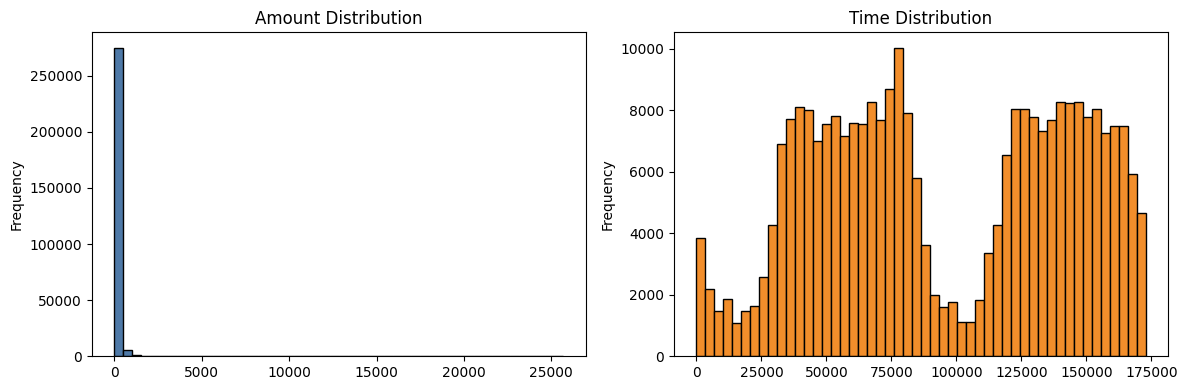

✓ CreditCardEDA initialized
  Dataset shape: (283726, 31)
  Target column: Class
  Output directory: /home/voldi/Projects/ai-ml/fraud-detection-model/reports/images

PCA FEATURES ANALYSIS
Analyzed 28 PCA features
✓ Saved PCA distributions: /home/voldi/Projects/ai-ml/fraud-detection-model/reports/images/cc_pca_distributions.png


In [6]:
# 5. Univariate Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
cc_df["Amount"].plot(
    kind="hist", bins=50, ax=axes[0], color="#4e79a7", edgecolor="black"
)
axes[0].set_title("Amount Distribution")
cc_df["Time"].plot(kind="hist", bins=50, ax=axes[1], color="#f28e2b", edgecolor="black")
axes[1].set_title("Time Distribution")
plt.tight_layout()
plt.show()

# PCA features distributions via CreditCardEDA
eda = CreditCardEDA(cc_df, target_column="Class", output_dir=REPORTS_IMG_DIR)
_ = eda.pca_features_analysis(save_plots=True)

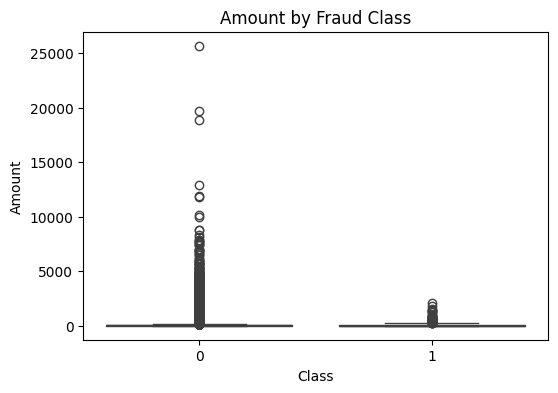

Top 10 PCA features by |corr| with Class:


V17   -0.3135
V14   -0.2934
V12   -0.2507
V10   -0.2070
V16   -0.1872
V3    -0.1823
V7    -0.1723
V11    0.1491
V4     0.1293
V18   -0.1053
dtype: float64

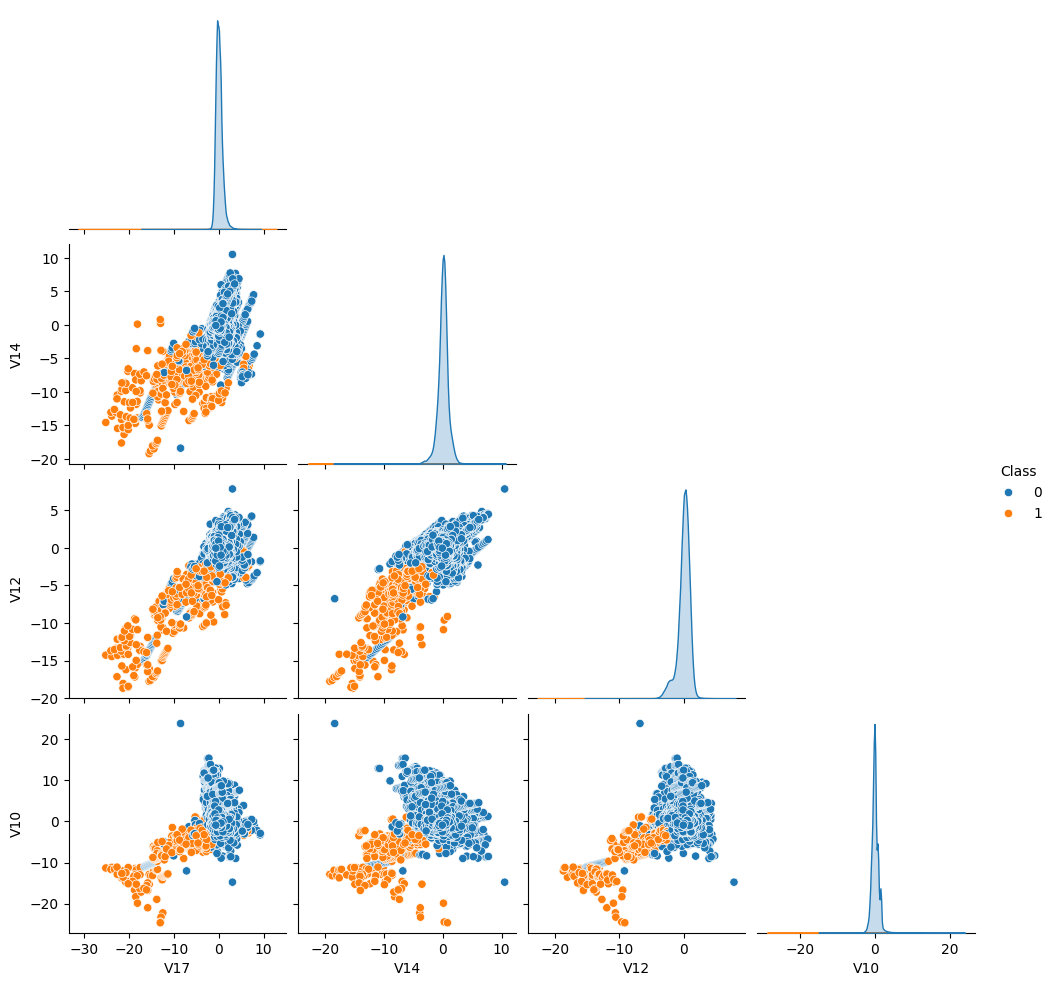

In [7]:
# 6. Bivariate Analysis vs Target
# Amount vs Class
plt.figure(figsize=(6, 4))
sns.boxplot(data=cc_df, x="Class", y="Amount")
plt.title("Amount by Fraud Class")
plt.show()

# Correlation with target for PCA features
pca_cols = [c for c in cc_df.columns if c.startswith("V") and c[1:].isdigit()]
corrs = {c: cc_df[c].corr(cc_df["Class"]) for c in pca_cols}
corr_series = pd.Series(corrs).sort_values(key=lambda s: s.abs(), ascending=False)
print("Top 10 PCA features by |corr| with Class:")
display(corr_series.head(10))

# Pairwise density for top 4 PCA features
top_feats = corr_series.head(4).index.tolist()
sns.pairplot(cc_df[top_feats + ["Class"]], hue="Class", diag_kind="kde", corner=True)
plt.show()

In [8]:
# 7. Class Distribution Analysis
imbalance = eda.analyze_class_imbalance(save_plot=True)
display(pd.DataFrame({k: [v] for k, v in imbalance.items() if k != "plot_saved"}))
print("Plot saved:", imbalance.get("plot_saved"))

✓ Saved class imbalance plot: /home/voldi/Projects/ai-ml/fraud-detection-model/reports/images/cc_class_imbalance.png


,fraud_count,legitimate_count,fraud_percentage,legitimate_percentage,imbalance_ratio,total_transactions
0,473,283253,0.1667,99.8333,598.8436,283726


Plot saved: /home/voldi/Projects/ai-ml/fraud-detection-model/reports/images/cc_class_imbalance.png


,fraud_count,total,fraud_rate
hours,,,
0,2,3931,0.0005
1,2,2213,0.0009
2,21,1573,0.0134
3,13,1818,0.0072
4,6,1082,0.0055


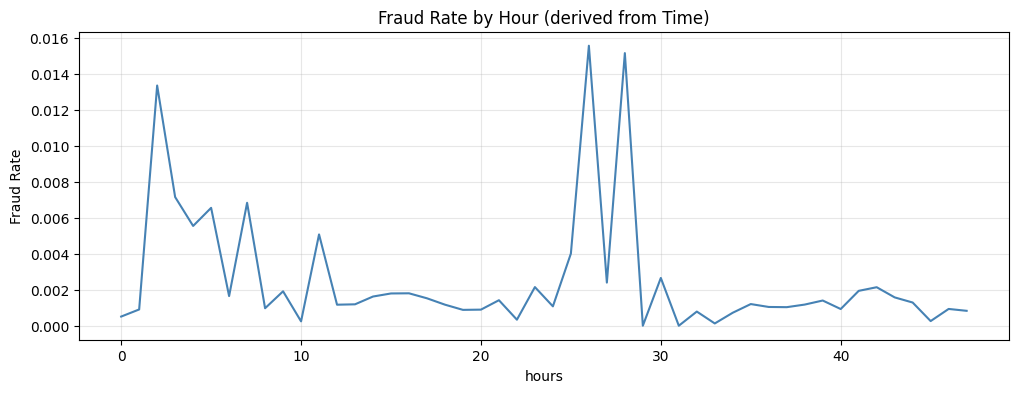

In [9]:
# 8. Time-Based Feature Engineering
df_fe = cc_df.copy()
df_fe["hours"] = (df_fe["Time"] / 3600).astype(int)
df_fe["day_bucket"] = (df_fe["Time"] // (24 * 3600)).astype(int)
hourly_stats = (
    df_fe.groupby("hours")["Class"]
    .agg(["sum", "count", "mean"])
    .rename(columns={"sum": "fraud_count", "count": "total", "mean": "fraud_rate"})
)
display(hourly_stats.head())
plt.figure(figsize=(12, 4))
hourly_stats["fraud_rate"].plot(color="steelblue")
plt.title("Fraud Rate by Hour (derived from Time)")
plt.ylabel("Fraud Rate")
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# 9. Scaling & Train/Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Features: numerical columns (keep it simple for notebook demo)
num_cols = ["Amount", "hours"]
X = df_fe[num_cols].copy()
y = df_fe["Class"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", len(X_train), "Test size:", len(X_test))

scaler_name = "standard"
scaler = StandardScaler() if scaler_name == "standard" else MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=num_cols, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=num_cols, index=X_test.index
)
X_train_scaled.head()

Train size: 226980 Test size: 56746


,Amount,hours
226238,-0.2294,1.0717
134253,-0.3312,-0.2935
186465,-0.2988,0.6925
149493,-0.2892,-0.0659
18461,-0.2620,-1.3553


In [11]:
# 10. Class Imbalance Handling (SMOTE)
from imblearn.over_sampling import SMOTE

print("Class distribution before SMOTE:", dict(y_train.value_counts()))
# SMOTE on training only
smote = SMOTE(
    random_state=42, k_neighbors=max(1, min(5, int((y_train == 1).sum()) - 1))
)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("Class distribution after SMOTE:", dict(pd.Series(y_train_res).value_counts()))

Class distribution before SMOTE: {0: np.int64(226602), 1: np.int64(378)}
Class distribution after SMOTE: {0: np.int64(226602), 1: np.int64(226602)}


In [12]:
# 11. Save Cleaned & Transformed Artifacts
cleaned_path = Path(PROCESSED_DIR) / "cleaned_creditcard_for_eda.csv"
cc_df.to_csv(cleaned_path, index=False)
print("Saved cleaned dataset to:", cleaned_path)

train_scaled_path = Path(PROCESSED_DIR) / "cc_train_scaled.csv"
test_scaled_path = Path(PROCESSED_DIR) / "cc_test_scaled.csv"
resampled_train_path = Path(PROCESSED_DIR) / "cc_train_smote_resampled.csv"

X_train_scaled.assign(Class=y_train).to_csv(train_scaled_path, index=False)
X_test_scaled.assign(Class=y_test).to_csv(test_scaled_path, index=False)
pd.DataFrame(X_train_res, columns=num_cols).assign(Class=y_train_res).to_csv(
    resampled_train_path, index=False
)
print("Saved train/test scaled and SMOTE-resampled artifacts.")

# Final report
eda.correlation_analysis(save_plots=True)
summary = eda.generate_eda_report()
summary

Saved cleaned dataset to: /home/voldi/Projects/ai-ml/fraud-detection-model/data/processed/cleaned_creditcard_for_eda.csv
Saved train/test scaled and SMOTE-resampled artifacts.
✓ Saved correlation heatmap: /home/voldi/Projects/ai-ml/fraud-detection-model/reports/images/cc_correlation_heatmap.png

CREDIT CARD EDA REPORT SUMMARY
Dataset: 283,726 rows × 31 columns
Target column: Class
Output directory: /home/voldi/Projects/ai-ml/fraud-detection-model/reports/images
  ✓ Pca Features Analysis
  ✓ Class Imbalance
  ✓ Correlation Analysis

Visualizations created: 2



{'pca_features_analysis': {'stats': {'V1': {'mean': 0.005917149836165761,
    'std': 1.948026141625471,
    'min': -56.407509631329,
    'max': 2.45492999121121,
    'skew': -3.273271248440309,
    'kurtosis': 32.727332486912616},
   'V2': {'mean': -0.0041347556281216905,
    'std': 1.6467029642463507,
    'min': -72.7157275629303,
    'max': 22.0577289904909,
    'skew': -4.6951619005404694,
    'kurtosis': 96.89817284108402},
   'V3': {'mean': 0.0016131193558786181,
    'std': 1.5086819162059164,
    'min': -48.3255893623954,
    'max': 9.38255843282114,
    'skew': -2.1519839570997124,
    'kurtosis': 25.186530332025544},
   'V4': {'mean': -0.0029663077203488635,
    'std': 1.4141840144475144,
    'min': -5.68317119816995,
    'max': 16.8753440335975,
    'skew': 0.6715041706728241,
    'kurtosis': 2.6187796082631523},
   'V5': {'mean': 0.0018275601130338598,
    'std': 1.3770082792800886,
    'min': -113.743306711146,
    'max': 34.8016658766686,
    'skew': -2.414079246966253,
   